# Preparation

In [1]:
%load_ext ipycache
import iminuit
%load_ext line_profiler
import matplotlib.pyplot as plt
%matplotlib inline
import multiprocessing
import numba
import numpy as np
import pandas as pd
import scipy as sp
from scipy import optimize
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

sns.set_style('darkgrid')
sns.set_context('notebook')

/home/fabrost/miniconda3/envs/spols190117/lib/python3.6/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated since IPython 4.0. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/home/fabrost/miniconda3/envs/spols190117/lib/python3.6/site-packages/ipycache.py:17: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils.traitlets import Unicode


In [2]:
results = pd.DataFrame()

In [3]:
def corrfunc(x, y, **kws):
    r, p = sp.stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate(f"\u03C1 = {r:.2f}\np = {p:.2f}", #unicode code for lowercase rho (ρ)
                xy=(.1, .9), xycoords=ax.transAxes)

# Load C14 models

In [4]:
import c14_models

# Read patient data

In [5]:
exp_data = pd.read_pickle('../../results/C14data_liver_samples_2019-03-20.pkl')
# exp_data['type'] = pd.Categorical(exp_data['type'])

In [6]:
exp_data.head()

,type,code,sample,Dbirth,Dcoll,d14C,error_measurement,N_cells,pathology,subject_age,valid
0,unsorted,PH1,ND380,1942.833333,2016.416667,0.078416,0.003981,NaN,N,73.583333,True
1,unsorted,PH2,ND388,1991.416667,2016.833333,0.025254,0.003912,NaN,N,25.416667,True
2,hepatocyte,PH3,ND381,1985.166667,2016.416667,0.040336,0.008788,58.0,N,31.250000,True
3,hepatocyte,PH4,ND382,1982.083333,2016.500000,0.018815,0.005342,52.0,N,34.416667,True
4,hepatocyte,PH6,ND022,1946.500000,2004.833333,0.075001,0.004711,62.0,N,58.333333,True


In [7]:
exp_data.describe()

,Dbirth,Dcoll,d14C,error_measurement,N_cells,subject_age
count,82.000000,83.000000,83.000000,83.000000,51.000000,82.000000
mean,1961.957317,2016.635542,0.042490,0.007400,62.617647,54.662602
std,19.834830,2.727045,0.022845,0.003629,28.015279,19.562783
min,1932.583333,2004.833333,0.005100,0.003912,12.000000,20.000000
25%,1946.500000,2016.750000,0.026300,0.004650,44.000000,37.500000
50%,1958.750000,2017.333333,0.039600,0.006400,59.000000,58.250000
75%,1979.833333,2017.458333,0.050800,0.009250,72.000000,69.333333
max,1997.333333,2019.750000,0.131107,0.021571,129.000000,84.666667


# Plot data 

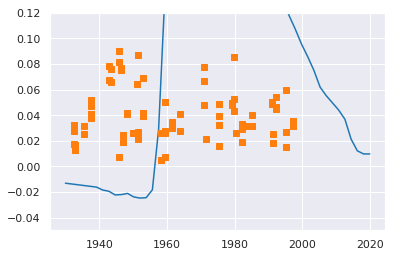

In [8]:
tt = np.linspace(1930, 2020)
plt.plot(tt, np.vectorize(c14_models.C_atm)(tt))
plt.plot(exp_data['Dbirth'], exp_data['d14C'], ls = 'None', marker = 's')
plt.ylim(-0.05, 0.12)
plt.show()

# Individual rates

In [9]:
@np.vectorize
def I1(Dbirth, Dcoll, loglam):
    """ For very high turnover rates return the atmospheric C14 concentration
        at the date of collection to avoid lengthy computations.
    """
    if loglam <= 10:
        lam = np.exp(loglam)
        return c14_models.I1(Dbirth, Dcoll, lam, t_eval=np.linspace(Dbirth, Dcoll))[1][-1]
    else:
        return c14_models.C_atm(Dcoll)

def diffI1(loglam, data):
    model_data = I1(data['Dbirth'], 
                    data['Dcoll'], 
                    loglam)
    diff = (model_data - data['d14C'])
    return diff

def SSE_individual(p, data):
    model_data = I1(data['Dbirth'], 
                    data['Dcoll'], 
                    p)
    sse = np.sum((model_data - data['d14C'])**2)
    return sse    

def plot_diffI1(loglammin, loglammax, data):
    loglams = np.linspace(loglammin, loglammax)
    diff = np.vectorize(diffI1, excluded=[1])(loglams, data)
    plt.title(data['code'])
    plt.plot(loglams, diff, label='Diff predicted to measured')
    plt.plot([loglammin, loglammax], [0, 0], color='black')

def individual_rate(i, loglam0=np.log(0.1)):
    try:
#         return np.exp(sp.optimize.brentq(diffI1, -8, 10, args=exp_data.iloc[i]))
        return np.exp(sp.optimize.newton(diffI1, loglam0, args=([exp_data.iloc[i]])))
    except:
        return np.nan
    
def individual_rate_SSE(i, loglam0=np.log(0.1)):
    r = np.exp(
            sp.optimize.minimize(
                SSE_individual, loglam0, args=(exp_data.iloc[i]), method='Nelder-Mead'
            )['x'][0]
        )
    return r

In [10]:
p=multiprocessing.Pool(processes=7)

/home/fabrost/miniconda3/envs/spols190117/lib/python3.6/site-packages/scipy/integrate/odepack.py:234: RuntimeWarning: invalid value encountered in greater_equal
  if not((dt >= 0).all() or (dt <= 0).all()):
/home/fabrost/miniconda3/envs/spols190117/lib/python3.6/site-packages/scipy/integrate/odepack.py:234: RuntimeWarning: invalid value encountered in less_equal
  if not((dt >= 0).all() or (dt <= 0).all()):


In [11]:
exp_data['individual_rate_SSE'] = p.map(individual_rate_SSE, range(len(exp_data)))

ValueError: The values in t must be monotonically increasing or monotonically decreasing; repeated values are allowed.

In [ ]:
exp_data['individual_rate_newton'] = p.map(individual_rate, range(len(exp_data)))

In [ ]:
tt = np.linspace(1930, 2020)
plt.plot(tt, np.vectorize(c14_models.C_atm)(tt))
plt.scatter(exp_data['Dbirth'], exp_data['d14C'], marker='s', c=np.log(exp_data['individual_rate_SSE']))
plt.colorbar()
plt.ylim(-0.05, 0.15)
plt.show()

# Compare to graphical solution

In [ ]:
%%cache -d ipycache graphical.pkl
fig, axs = plt.subplots(int(np.ceil(len(exp_data)/8)), 8, sharex=True, sharey=True, figsize=(8.3, 11.7))

for ax in axs[-1]:
    ax.set_xlabel(u'λ')
for ax in axs[:,0]:
    ax.set_ylabel(u'ΔC14')
    
axs = axs.flatten()
loglammin, loglammax = -10, 5
loglams = np.linspace(loglammin, loglammax)
for (i, data), ax in zip(exp_data.iterrows(), axs):
    diff = np.vectorize(diffI1, excluded=[1])(loglams, data)
    ax.set_title(data['code'])
    ax.plot(loglams, diff, label='Diff predicted to measured')
    ax.axhline(0, color='black')
    ax.axvline(np.log(data['individual_rate_SSE']), color='black')
    
ax.set_xlim(loglammin, loglammax)
ax.set_ylim(-0.07, 0.07)
plt.tight_layout()
plt.savefig('../../results/plots/individual_rate_solution.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Plot rates

In [ ]:
ax = sns.catplot(data=exp_data, x='type', y='individual_rate_SSE', kind='box')
ax.set_xticklabels(rotation=30)
plt.show()

In [ ]:
ax = sns.catplot(data=exp_data,  y='individual_rate_SSE', kind='box')
plt.show()

# Detect outliers based on IQR

In [ ]:
# Computing IQR
Q1 = exp_data['individual_rate_SSE'].quantile(0.25)
Q3 = exp_data['individual_rate_SSE'].quantile(0.75)
IQR = Q3 - Q1

# Selecting Values between Q1-1.5IQR and Q3+1.5IQR
exp_data['rate_is_not_outlier'] = exp_data.eval('(@Q1 - 1.5 * @IQR) <= individual_rate_SSE <= (@Q3 + 1.5 * @IQR)')

In [ ]:
ax = sns.catplot(data=exp_data.query('rate_is_not_outlier'), x='type', y='individual_rate_SSE', kind='box')
# sns.swarmplot(data=exp_data, x='type', y='individual_rate_SSE', color='black', size=2)
ax.set_xticklabels(rotation=30)
plt.show()

# Sanity check of the results by comparing the two methods:

In [ ]:
exp_data.query('rate_is_not_outlier').query('(individual_rate_SSE - individual_rate_newton)**2 > (1e-3)**2')

# Analysing results

I use the values obtained with SSE

In [ ]:
exp_data['cell_age'] = 1. / exp_data['individual_rate_SSE']

In [ ]:
exp_data.head()

In [ ]:
sns.pairplot(exp_data.query('rate_is_not_outlier'),
            x_vars = ['subject_age', 'Dbirth', 'Dcoll'],
            y_vars = ['cell_age', 'individual_rate_SSE'],
            hue = 'type')
plt.show()

# Plot for Olaf

## Rate

In [ ]:
plot_data = exp_data.query('rate_is_not_outlier').query('type in ["hepatocyte", "non-hepatocyte", "unsorted"]')

In [ ]:
plot_data['type'].cat.remove_unused_categories(inplace=True)

In [ ]:
sns.set_context('paper')

In [ ]:
ax = sns.lmplot(x='subject_age', y='individual_rate_SSE', col='type', data=plot_data,
                col_order=['hepatocyte', 'non-hepatocyte', 'unsorted'])
ax.set_axis_labels(x_var='age of person', y_var='turnover rate (per year)')
plt.savefig('../../results/plots/individual_rate_age.pdf', dpi=300, bbox_inches='tight')
plt.show()

No significant correlation in the above data:

In [ ]:
plot_data.groupby('type').apply(lambda g: pd.Series({key: value for key, value in zip(['r', 'p'],
    sp.stats.pearsonr(g['subject_age'], g['individual_rate_SSE']))}))

In [ ]:
plot_data.groupby('type').apply(lambda g: smf.ols('individual_rate_SSE ~ subject_age', data=g).fit().params)

## Cell Age

In [ ]:
ax = sns.lmplot(x='subject_age', y='cell_age', col='type', data=plot_data,
               col_order=['hepatocyte', 'non-hepatocyte', 'unsorted'])
ax.set_axis_labels(x_var='age of person', y_var='average cell age (years)')
plt.savefig('../../results/plots/individual_rate_age.pdf', dpi=300, bbox_inches='tight')
plt.show()

No significant correlation in the above data:

In [ ]:
plot_data.groupby('type').apply(lambda g: pd.Series({key: value for key, value in zip(['r', 'p'],
    sp.stats.pearsonr(g['subject_age'], g['cell_age']))}))

In [ ]:
plot_data.groupby('type').apply(lambda g: smf.ols('cell_age ~ subject_age', data=g).fit().params)

# Export

In [ ]:
# exp_data.to_excel('./write/C14_data.xlsx')